In [1]:
import datetime

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import filtfilt, butter
from scipy import signal

%matplotlib inline

In [2]:
# Matplotlib settings to make the plots look a little nicer.
plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
filename_to_datestr = lambda fname : fname.split('_')[-2]

def read_file(fname):
    edge_df = pd.read_csv(fname, names=['Edge_km'])
    edge_df['Edge_km'] *= 10
    
    dt_args = list(map(int, filename_to_datestr(fname).split('-'))) + [12]
    start_time = datetime.datetime(*dt_args)
    
    edge_df['UTC'] = [start_time + i*datetime.timedelta(minutes=1) for i in range(edge_df.shape[0])]
    return edge_df

# fname = 'detected_edge_2018-12-28_T3.csv'
# edge_df = read_file(fname)
# display(edge_df)

In [4]:
def plot_initial_edge(edge_df):
    fig = plt.figure(figsize=(15,6))
    ax  = fig.add_subplot(111)
    xx  = edge_df['UTC']
    yy  = edge_df['Edge_km']
    ax.plot(xx,yy)
    ax.set_xlabel('Time [UT]')
    ax.set_ylabel('Detected Edge [km]')
    plt.show()
    return

# plot_initial_edge(edge_df)

In [5]:
def get_time_differences(edge_df):
    # Calculate time difference between samples
    utcs = [x.to_pydatetime() for x in edge_df['UTC']]
    dt_arr = np.diff(utcs)

    # Convert from time delta to total seconds
    dt_sec = [x.total_seconds() for x in dt_arr]
    
    # What are the time differences between data points?
    # It should only be 1 since the Grape takes 1 measurement every second.
    # But, it's not.
    unique_time_differences = np.unique(dt_sec)
    print(unique_time_differences)
    return unique_time_differences

# get_time_differences(edge_df)

In [6]:
# FILTERBREAK=0.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
# FILTERORDER=6
# b, a    = butter(FILTERORDER, FILTERBREAK, analog=False, btype='low')
# rs_df['Edge_km_1'] = filtfilt(b, a, rs_df['Edge_km'])

def plot_scatter_edge(edge_df, title):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    xx = edge_df['UTC']
    yy = edge_df['Edge_km']
    ax.scatter(xx, yy, label='Edge_km')
    ax.plot(xx, yy, label='Edge_km_1', color='orange')
    ax.legend(loc='upper right')

    fig.autofmt_xdate()
    ax.set_ylabel('Detected Edge [km]')
    ax.set_title('Resampled Dataset\n' + title)
    plt.show()
    return

# plot_scatter_edge(edge_df, fname)

In [10]:
def plot_spectrogram(edge_df, title):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,8), dpi=250)
    # ax  = fig.add_subplot(111)

    xx = edge_df['Edge_km']        # Signal
    fs = 1./datetime.timedelta(minutes=1).total_seconds()   # Sampling Frequency

    # Number of segments for each window of the FFT.
    # Since MSTIDs have a period of 15 to 60 min, a window
    # of 4 hr is reasonable since that will let in four full
    # periods of 60 min.
    nperseg = int((4.*3600.)/datetime.timedelta(minutes=1).total_seconds())
    noverlap = int(0.9*nperseg)
    f, t, Sxx = signal.spectrogram(xx, fs, nperseg=nperseg, window='hamming', noverlap=noverlap)

    # Convert seconds to datetimes.
    t_dt = [edge_df['UTC'][0] + datetime.timedelta(seconds=x) for x in t]

    ax.grid(False)
    mpbl = ax.pcolormesh(t_dt, f, 10.*np.log10(Sxx))
    cbar = plt.colorbar(mpbl,label='Power Spectral Density [dB]')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(title)

    fig.autofmt_xdate()
    plt.show()
    
    # Remove 0 frequency component.
    f_1   = f[1:]
    Sxx_1 = Sxx[1:,:]

    # Convert f to period in minutes
    T_min = 1./(60.*f_1)

    # Reverse T vector
    T_min  = T_min[::-1]
    Sxx_1  = Sxx_1[::-1,:]

    fig = plt.figure(figsize=(18,12))

    ax_0  = fig.add_subplot(211)
    xx    = edge_df['UTC']
    yy    = edge_df['Edge_km']
    ax_0.plot(xx,yy,ls='',marker='.',label='Edge_km')
    yy  = edge_df['Edge_km']
    ax_0.plot(xx,yy,label='Edge_km')
    #ax_0.legend(loc='upper right')
    fig.autofmt_xdate()
    ax_0.set_ylabel('Detected Edge [km]')
    ax_0.set_title(title)

    ax_1  = fig.add_subplot(212)
    ax_1.grid(False)
    #mpbl = ax_1.pcolormesh(t_dt, T_min, 10.*np.log10(Sxx_1))
    mpbl = ax_1.pcolormesh(t_dt, T_min, Sxx_1)
    cbar = plt.colorbar(mpbl,label='Power Spectral Density')
    ax_1.set_ylabel('Period [min]')
    ax_1.set_xlabel('Time [UT]')
    #ax_1.set_ylim(0,30)
    fig.autofmt_xdate()

    ax_0_pos = list(ax_0.get_position().bounds)
    ax_1_pos = list(ax_1.get_position().bounds)
    ax_0_pos[2] = ax_1_pos[2]
    ax_0.set_position(ax_0_pos)

    plt.show()
    return

# plot_spectrogram(edge_df)

In [11]:
def run_all(fname):
#     fname = 'detected_edge_2018-12-28_T3.csv'
    edge_df = read_file(fname)
    display(edge_df)
#     plot_initial_edge(edge_df)
    plot_scatter_edge(edge_df, fname)
    get_time_differences(edge_df)
    plot_spectrogram(edge_df, fname)

,%Noise
Path,
trimmed_edges/detected_edge_2019-05-24_T2.csv,0.000000
trimmed_edges/detected_edge_2019-06-01_T1.csv,0.000000
trimmed_edges/detected_edge_2019-06-02_T2.csv,0.000000
trimmed_edges/detected_edge_2019-06-16_T2.csv,0.000000
trimmed_edges/detected_edge_2019-05-26_T1.csv,0.025035


,Edge_km,UTC
0,540,2019-05-24 12:00:00
1,610,2019-05-24 12:01:00
2,680,2019-05-24 12:02:00
3,690,2019-05-24 12:03:00
4,690,2019-05-24 12:04:00
...,...,...
714,0,2019-05-24 23:54:00
715,0,2019-05-24 23:55:00
716,0,2019-05-24 23:56:00
717,0,2019-05-24 23:57:00


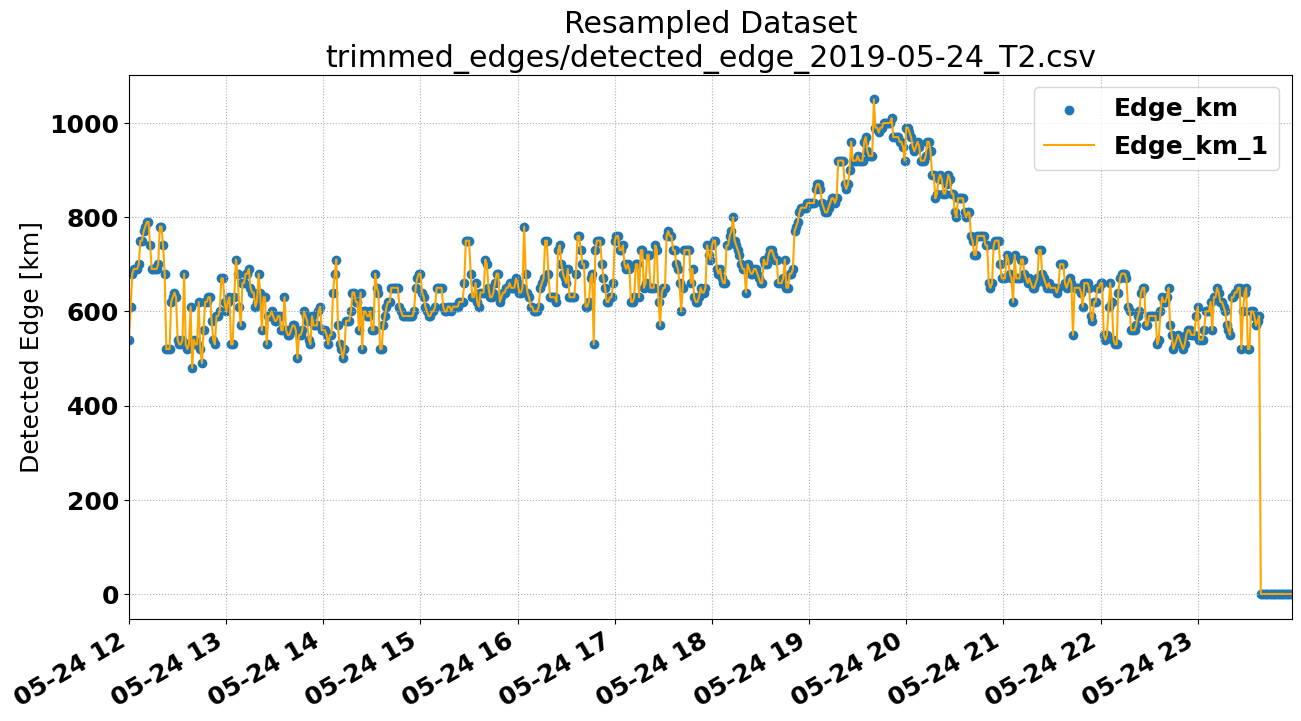

[60.]


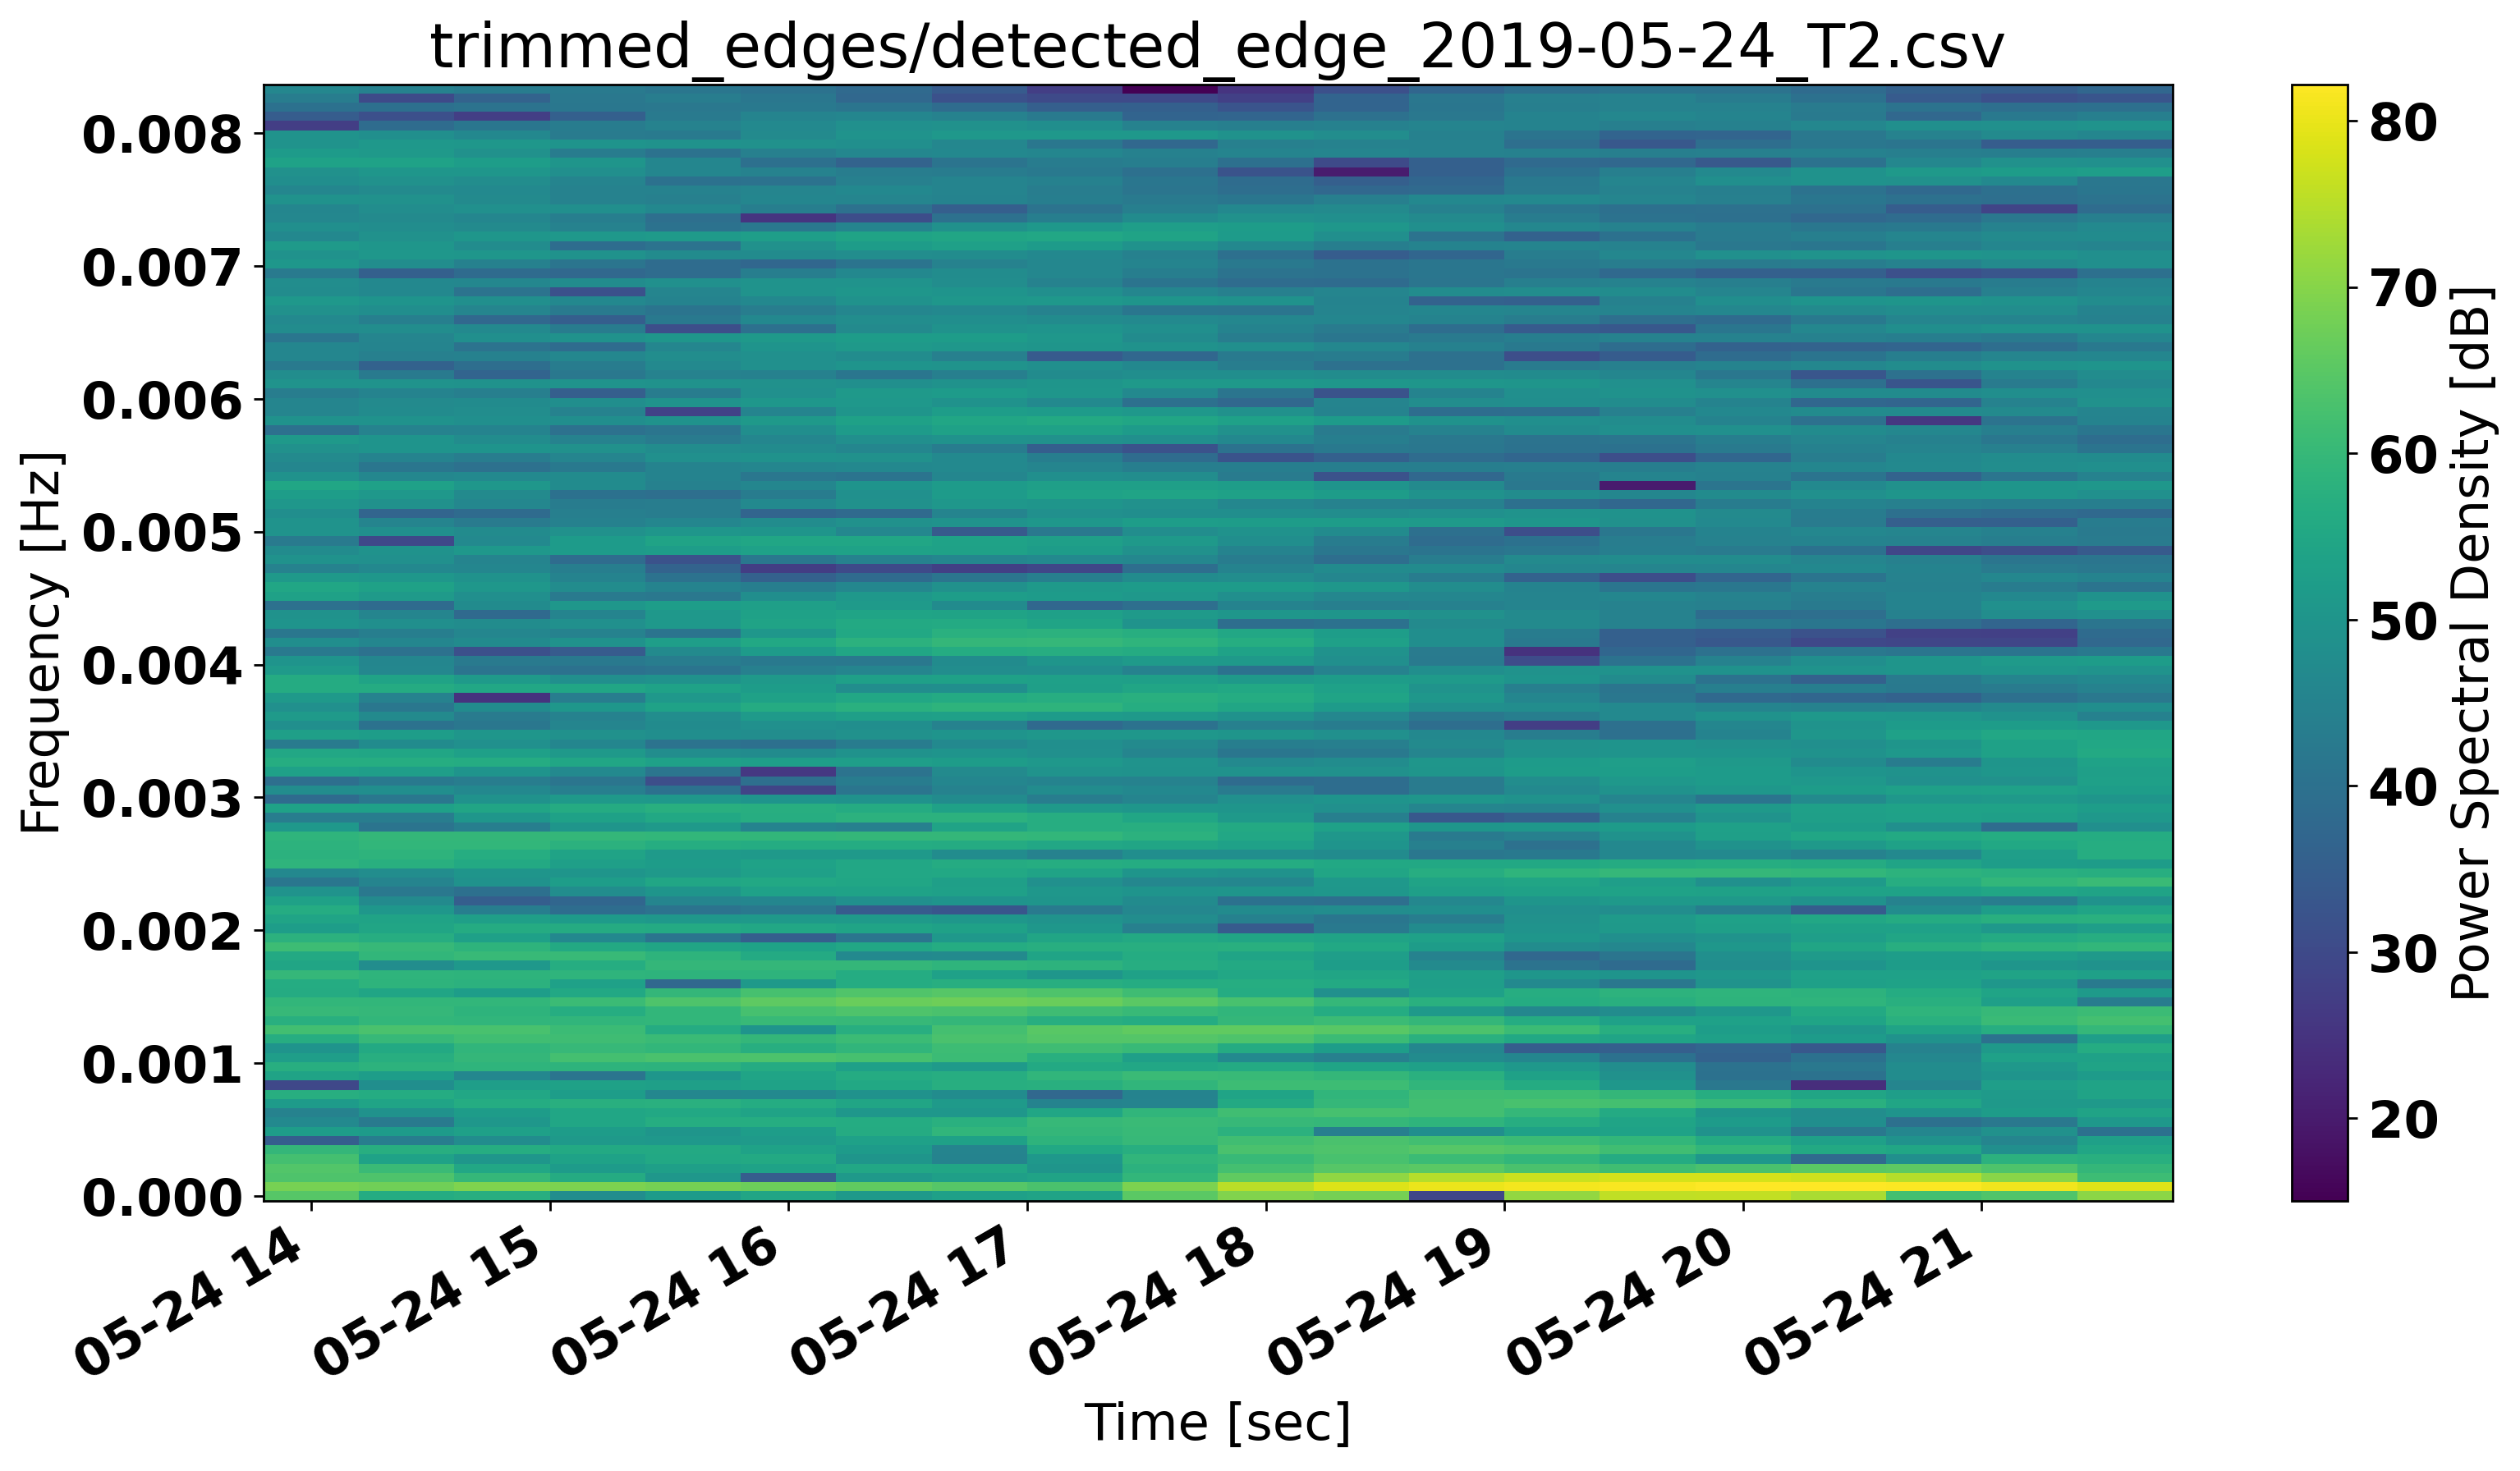

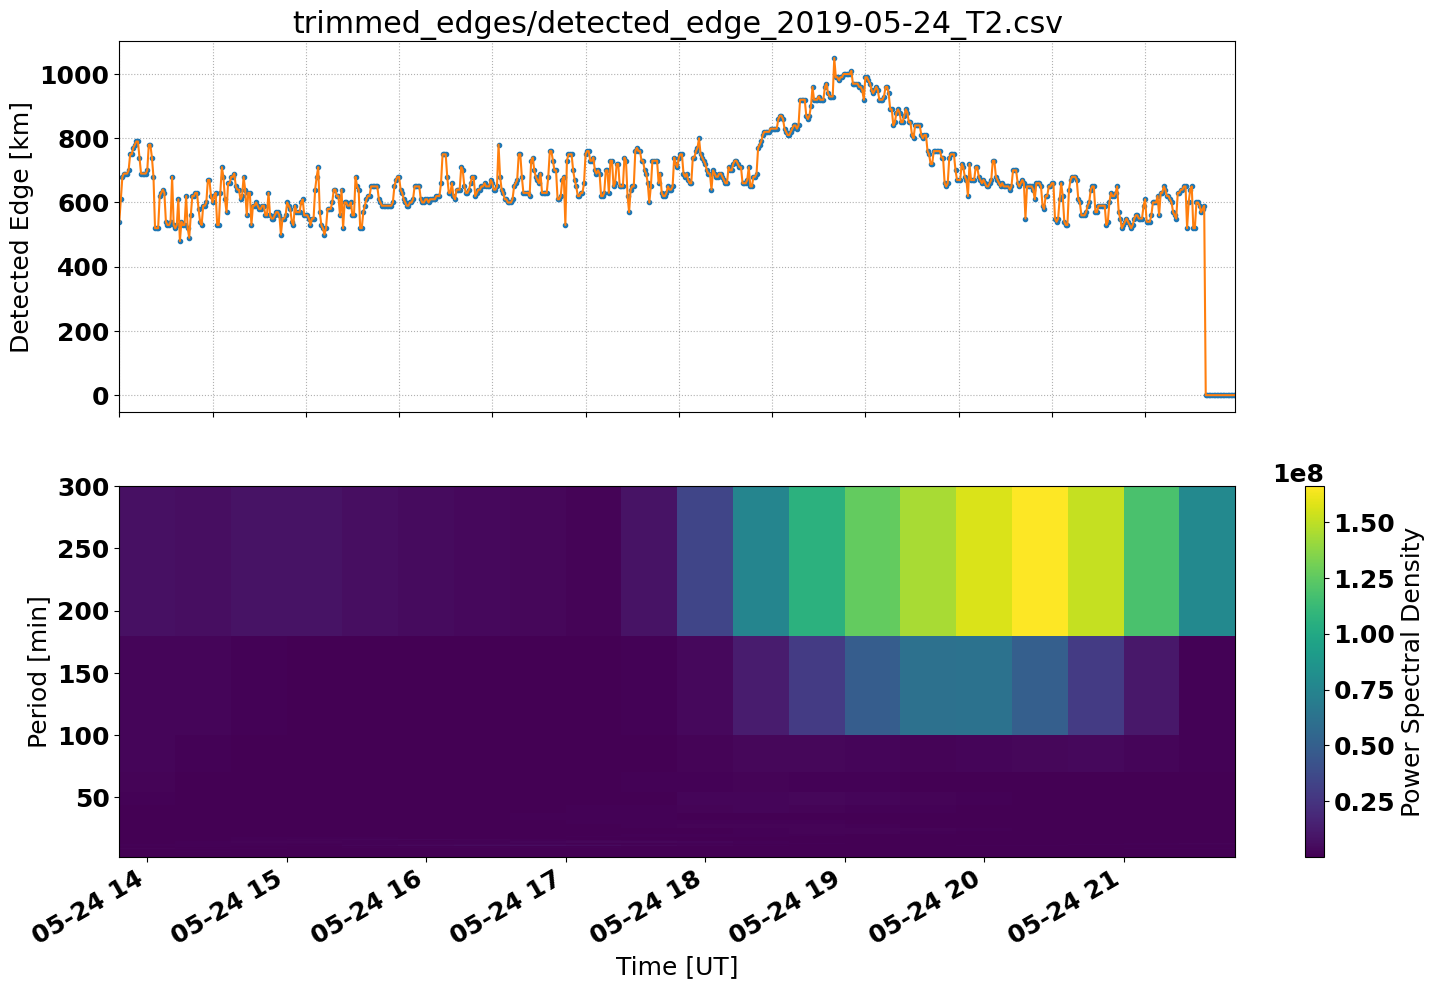

,Edge_km,UTC
0,430,2019-06-01 12:00:00
1,490,2019-06-01 12:01:00
2,490,2019-06-01 12:02:00
3,500,2019-06-01 12:03:00
4,510,2019-06-01 12:04:00
...,...,...
714,0,2019-06-01 23:54:00
715,0,2019-06-01 23:55:00
716,0,2019-06-01 23:56:00
717,0,2019-06-01 23:57:00


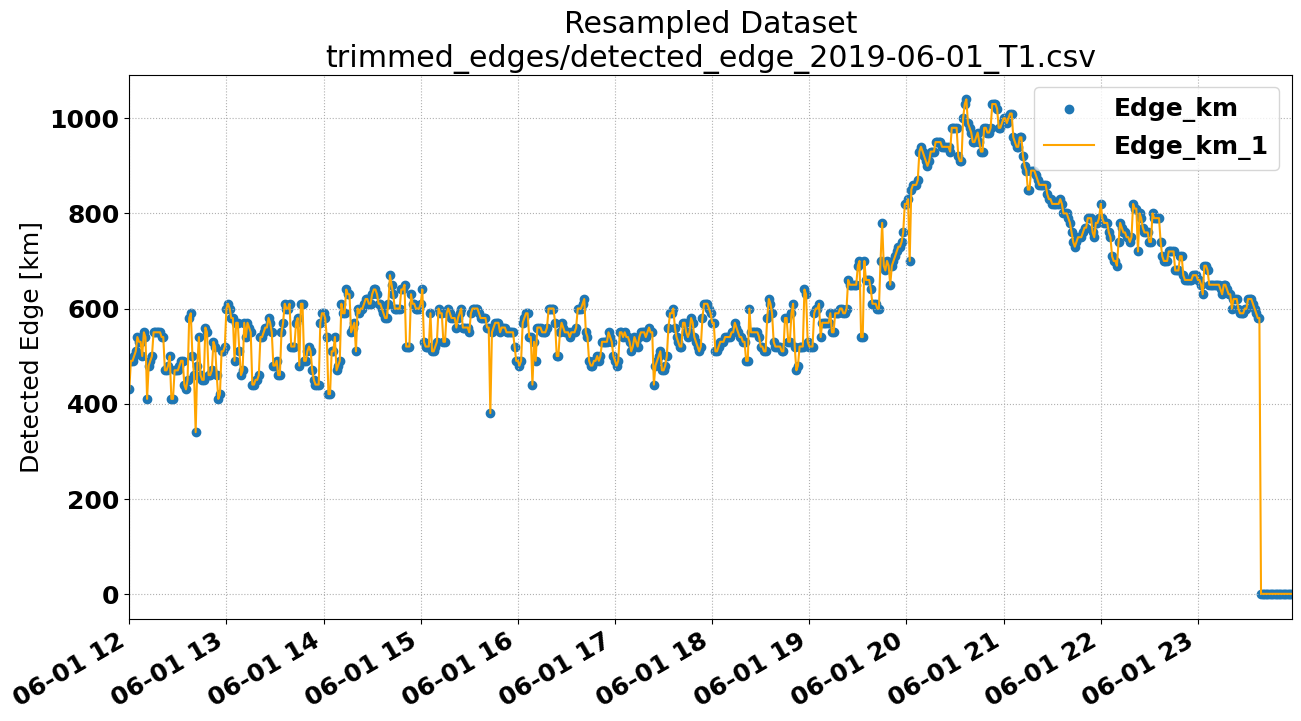

[60.]


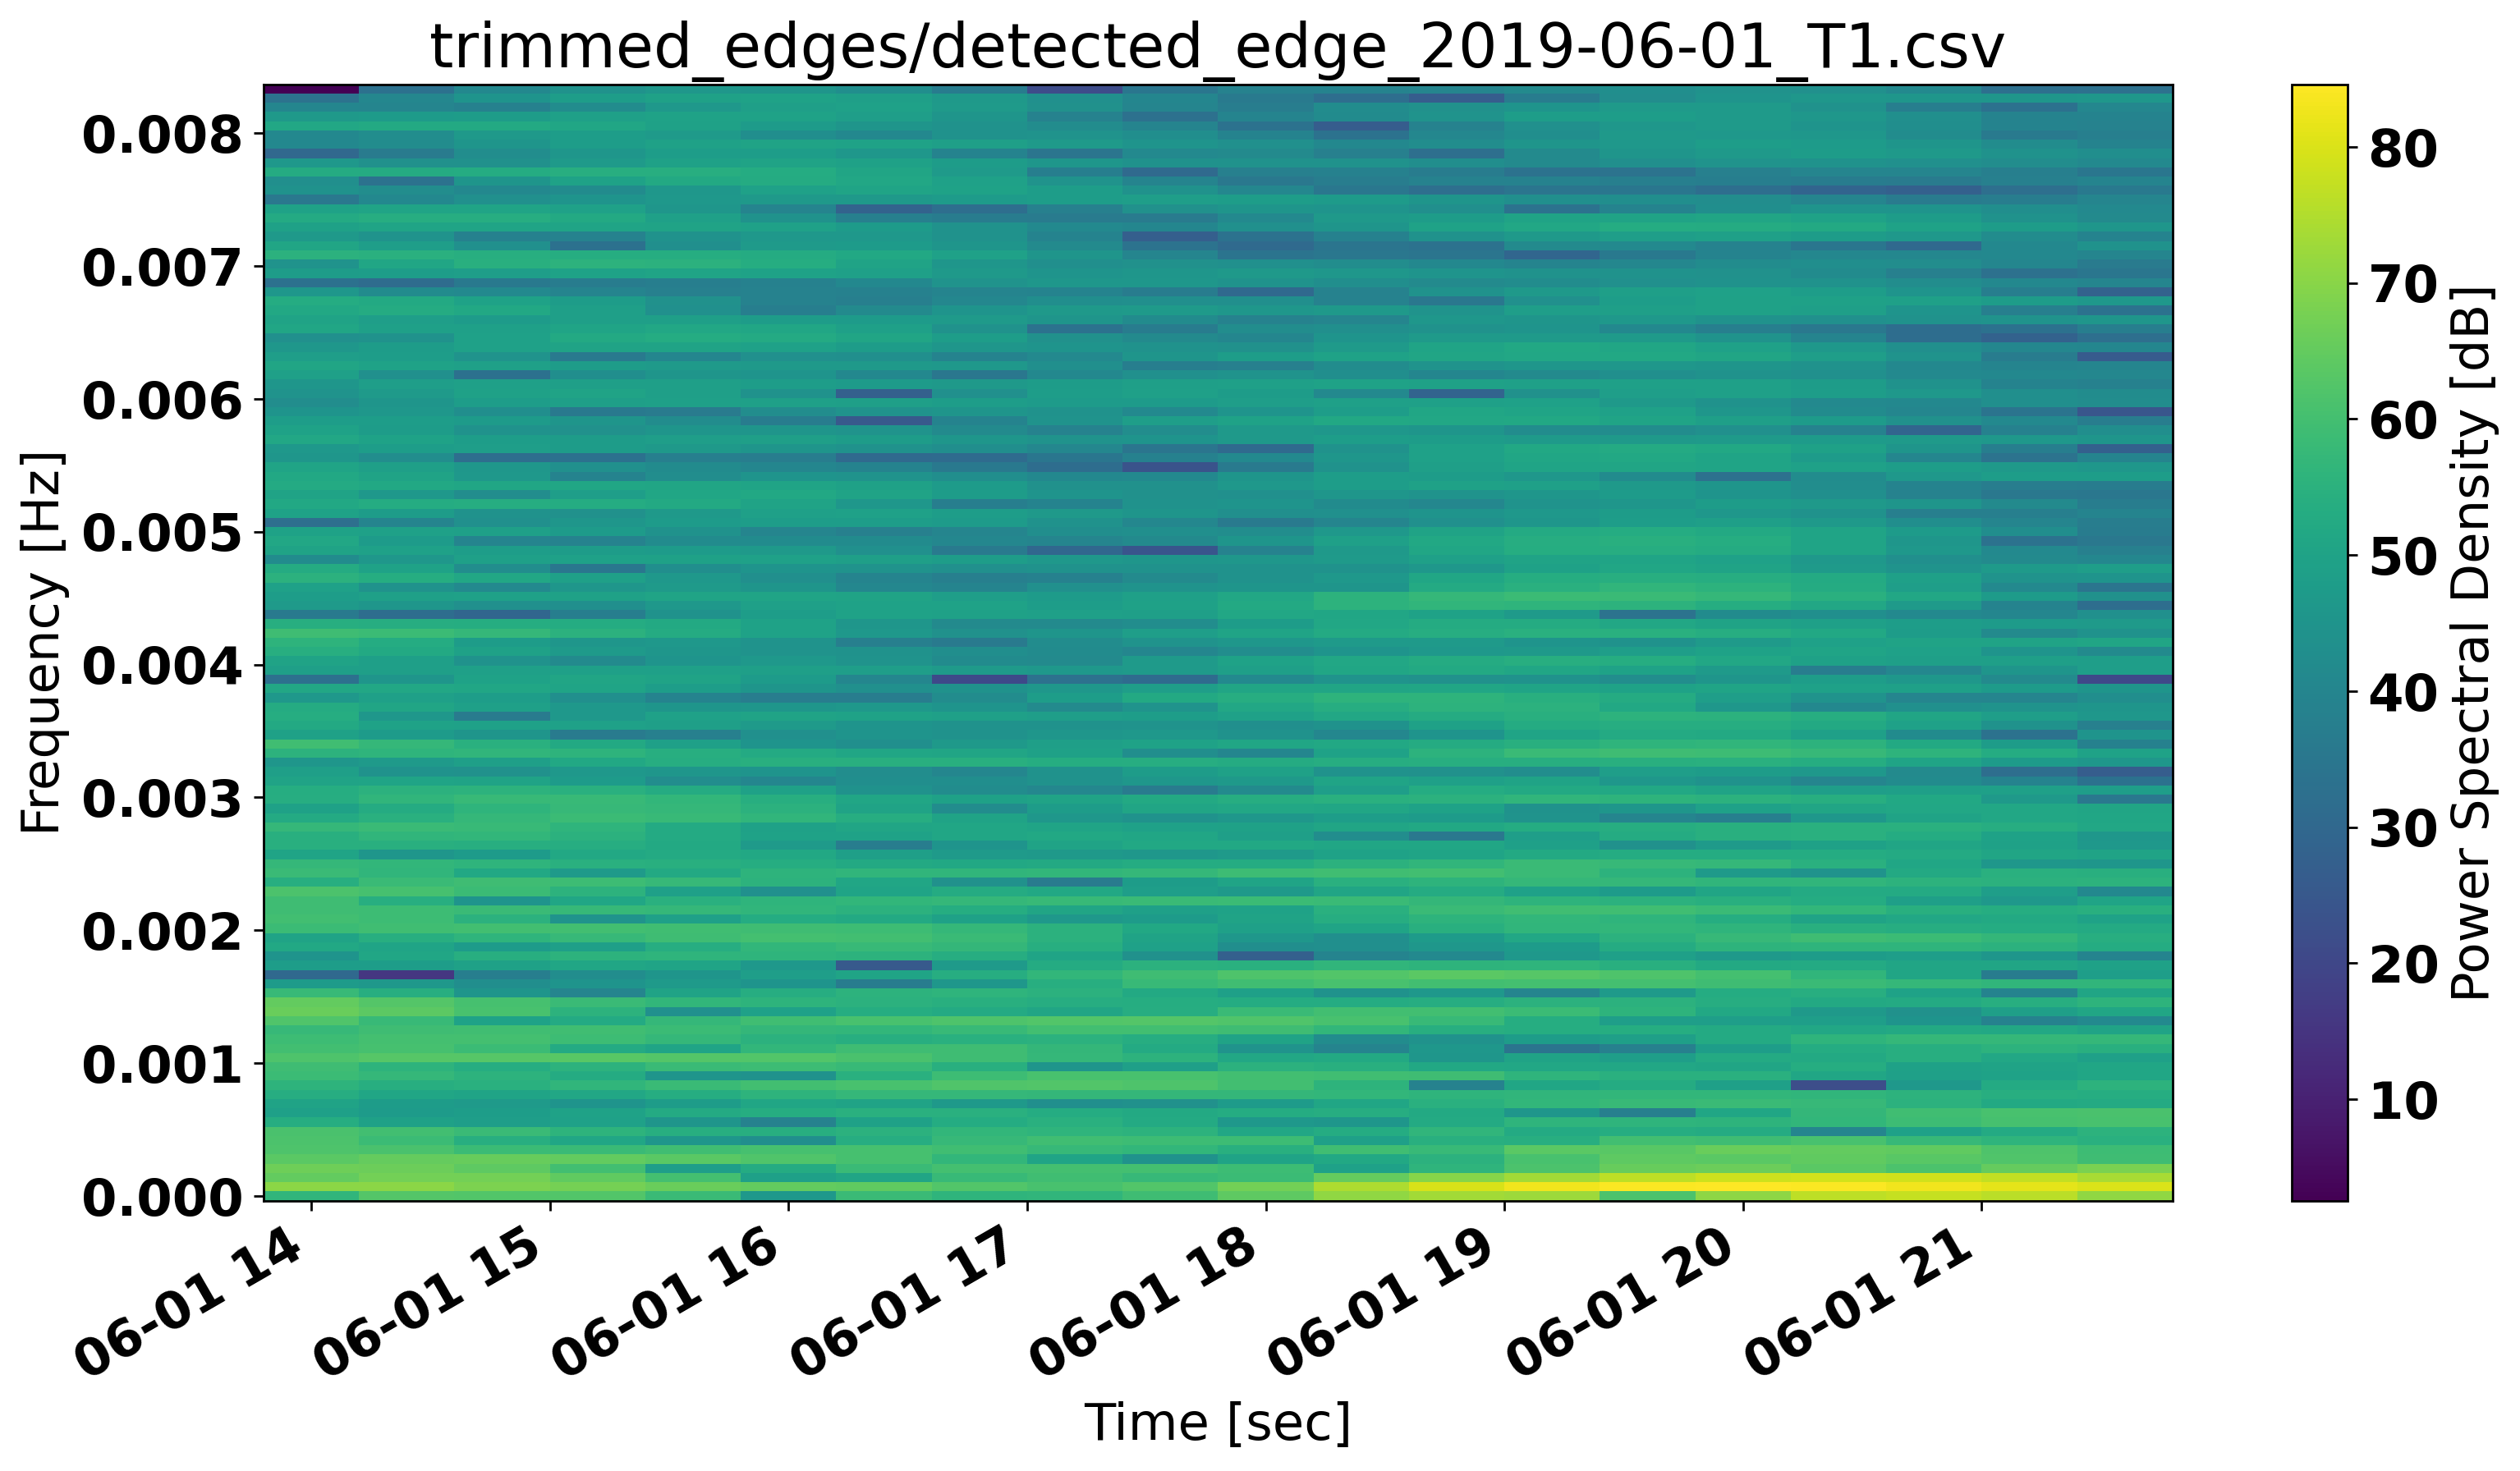

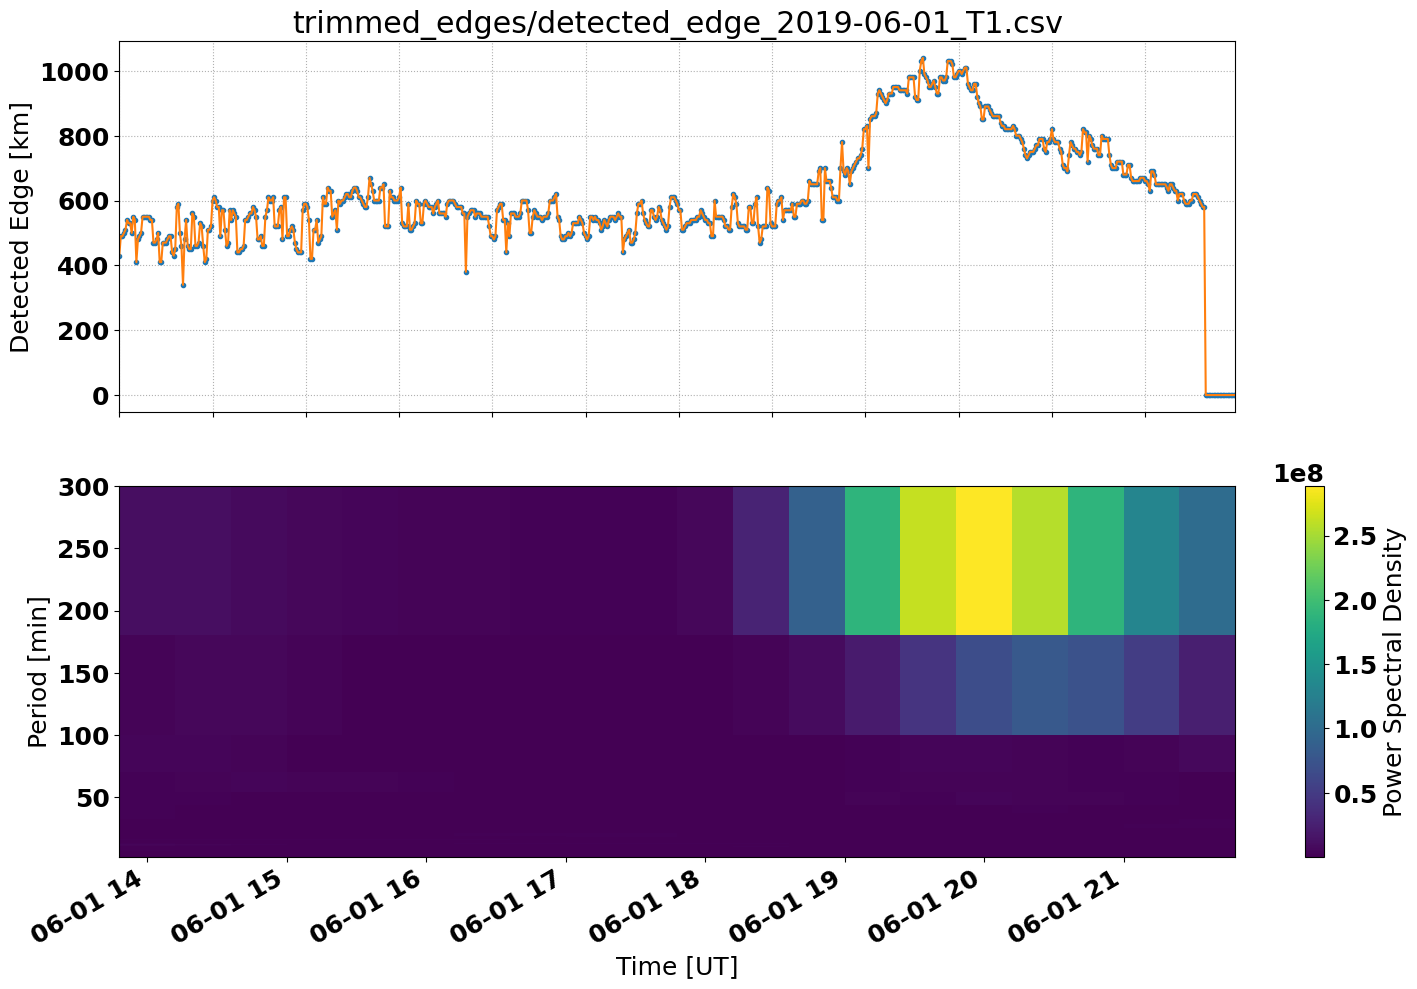

,Edge_km,UTC
0,650,2019-06-02 12:00:00
1,620,2019-06-02 12:01:00
2,610,2019-06-02 12:02:00
3,550,2019-06-02 12:03:00
4,500,2019-06-02 12:04:00
...,...,...
714,0,2019-06-02 23:54:00
715,0,2019-06-02 23:55:00
716,0,2019-06-02 23:56:00
717,0,2019-06-02 23:57:00


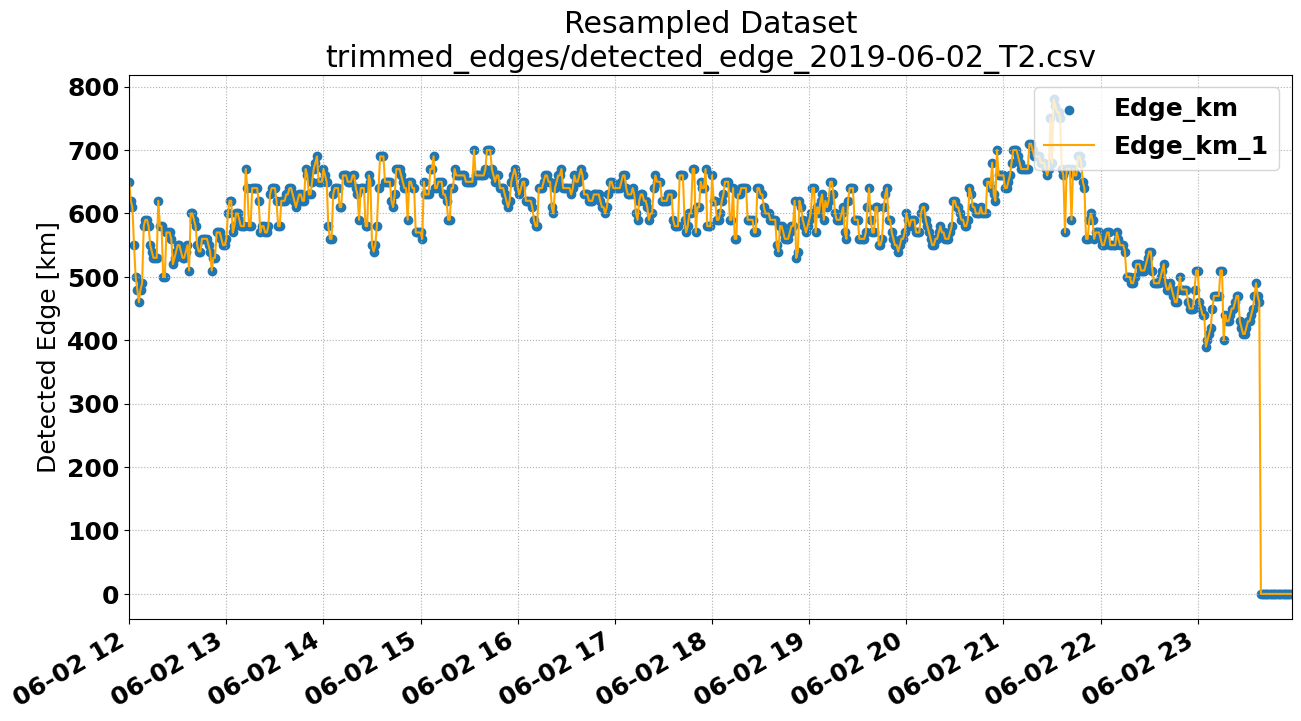

[60.]


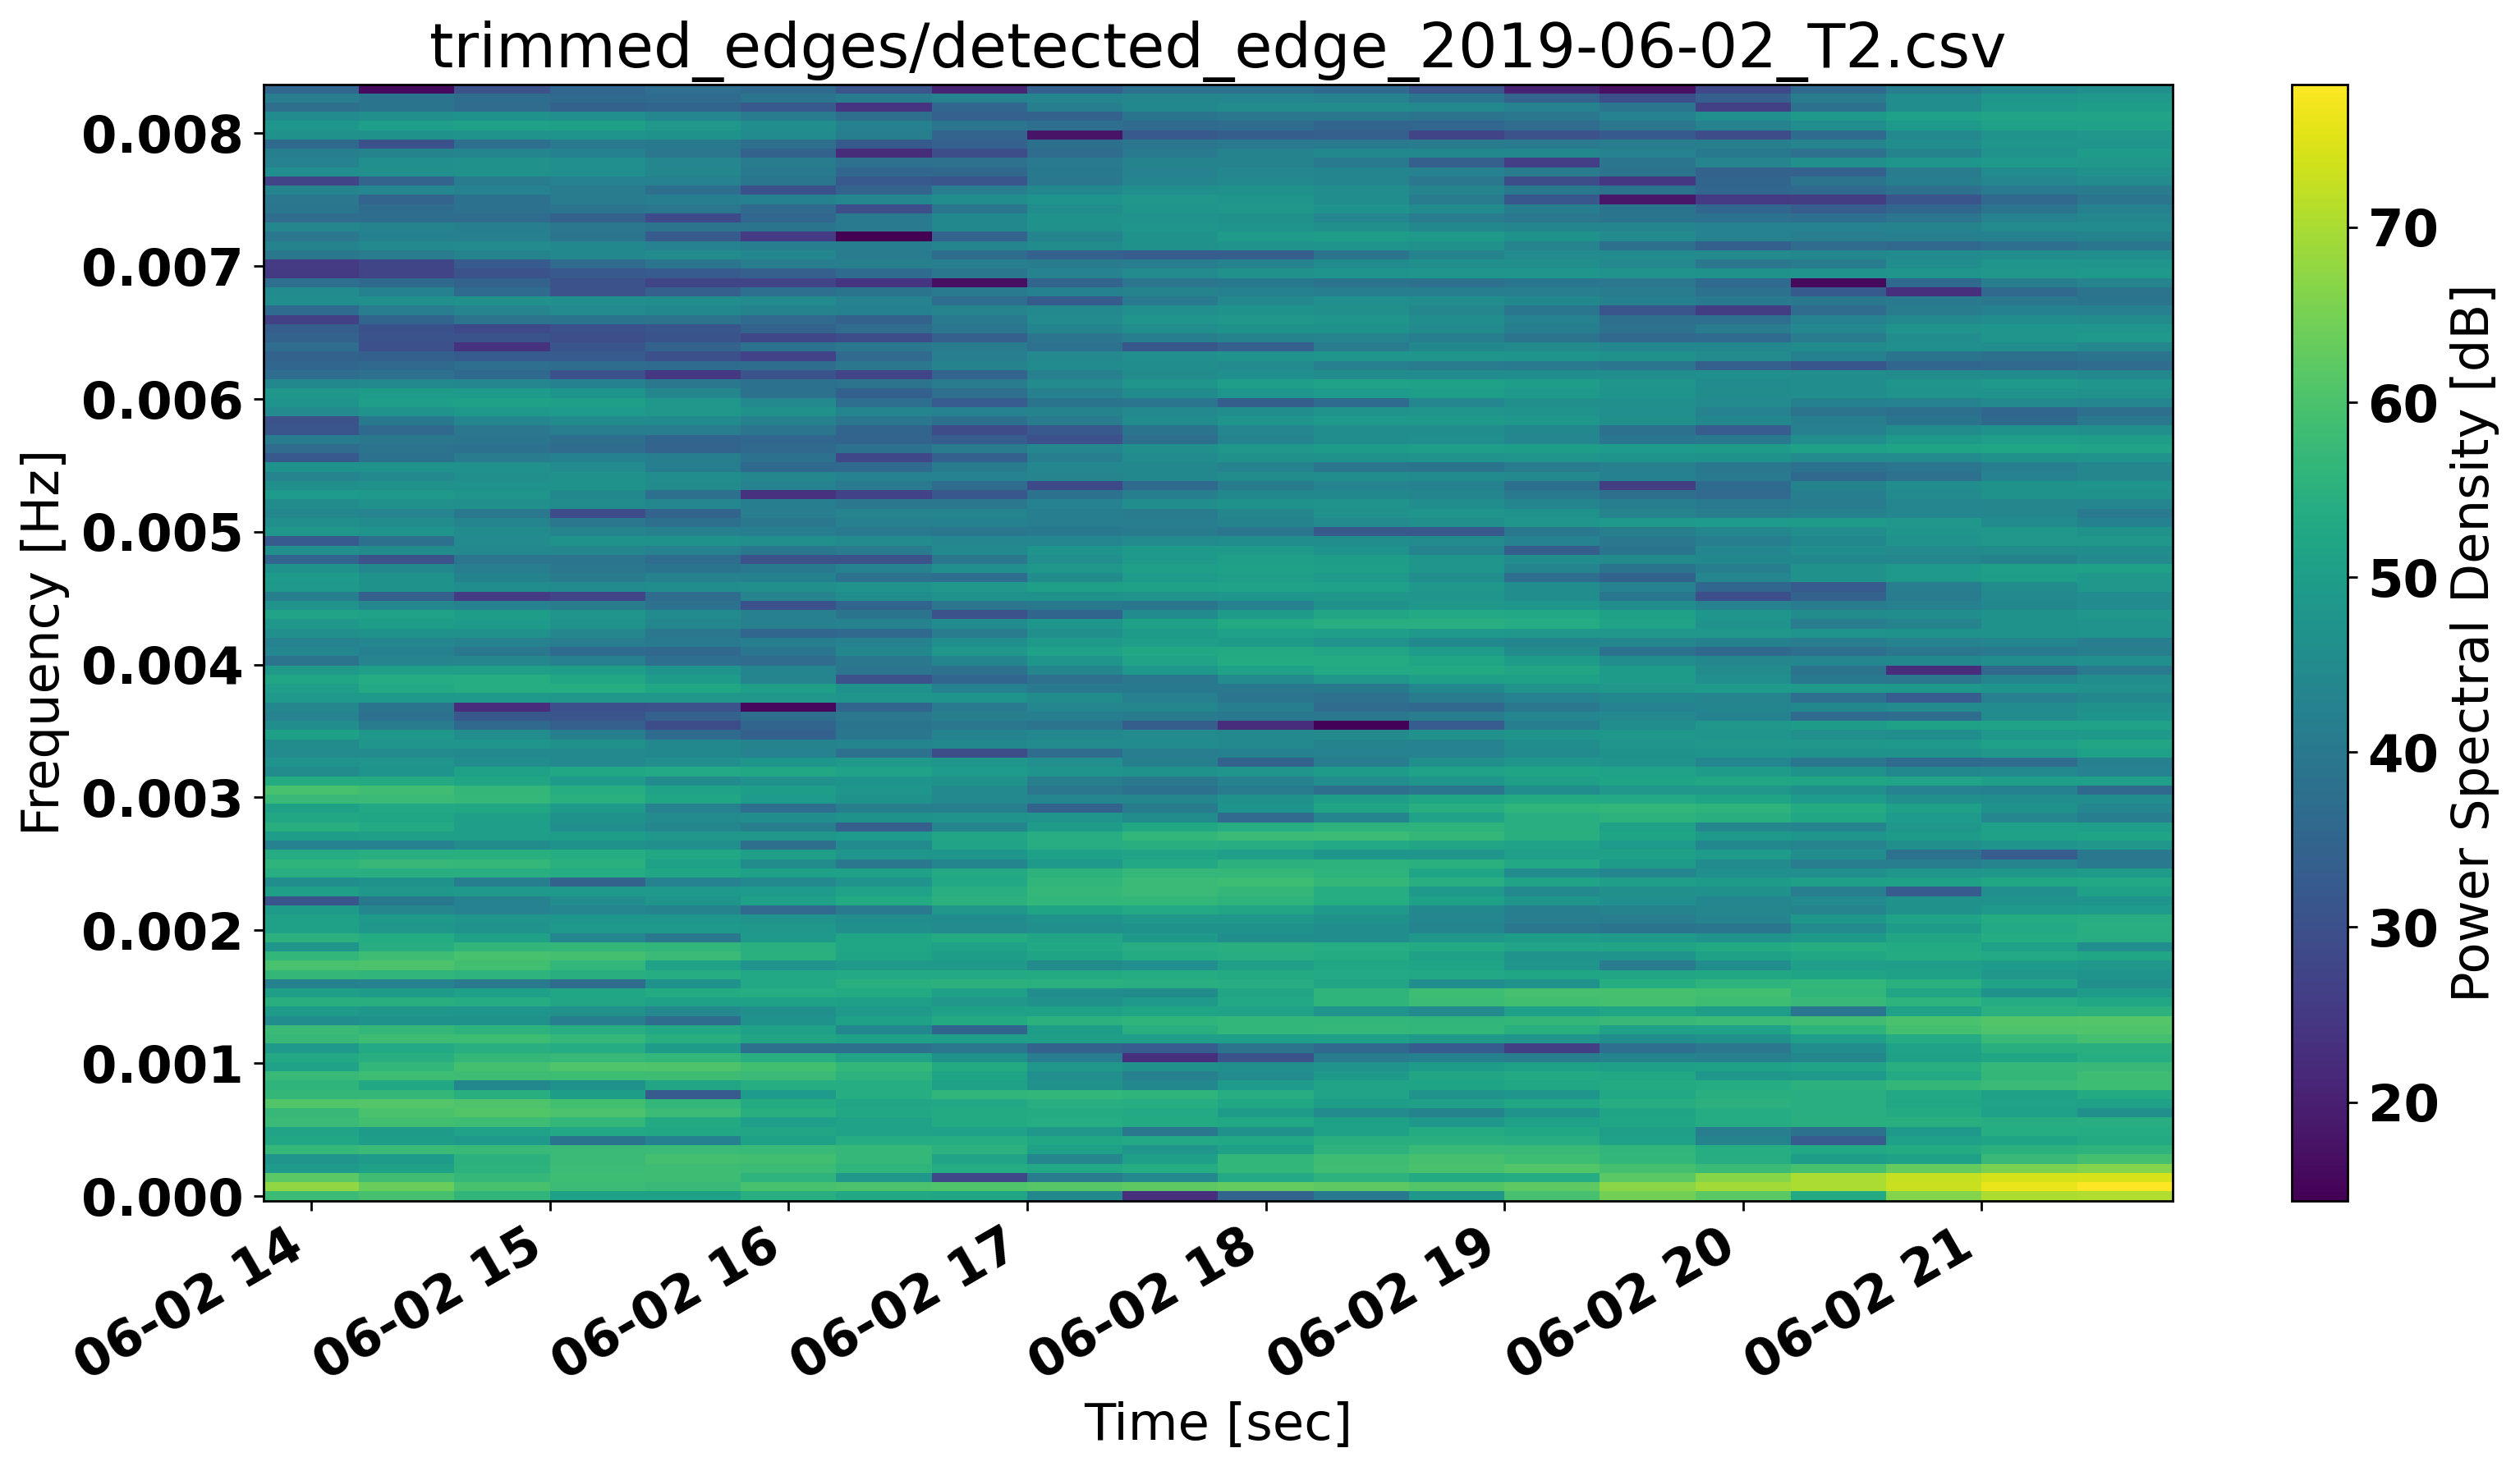

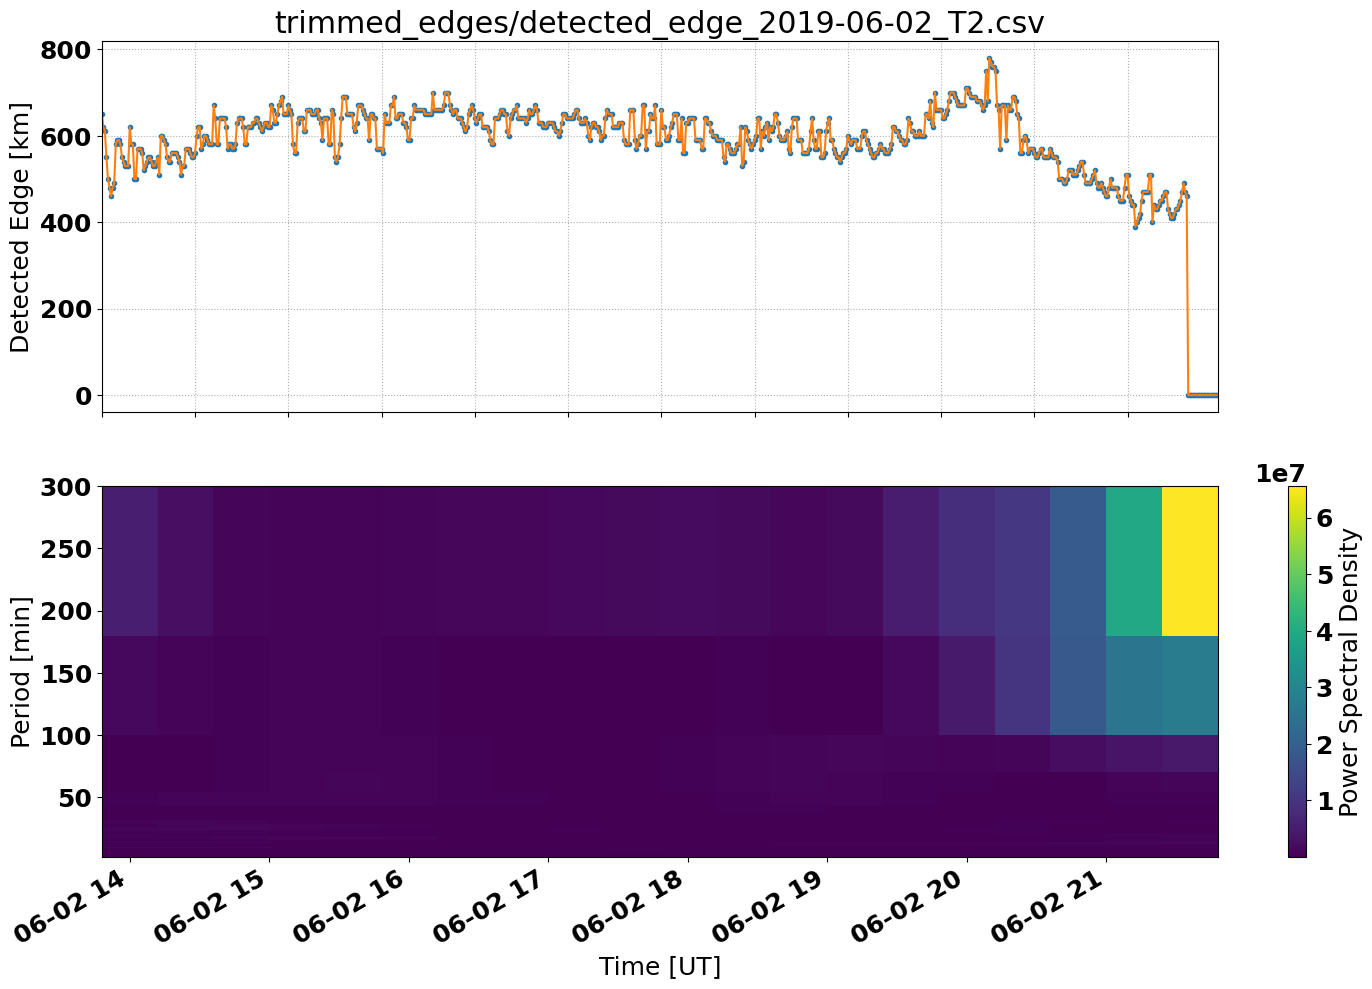

,Edge_km,UTC
0,460,2019-06-16 12:00:00
1,470,2019-06-16 12:01:00
2,470,2019-06-16 12:02:00
3,460,2019-06-16 12:03:00
4,470,2019-06-16 12:04:00
...,...,...
714,0,2019-06-16 23:54:00
715,0,2019-06-16 23:55:00
716,0,2019-06-16 23:56:00
717,0,2019-06-16 23:57:00


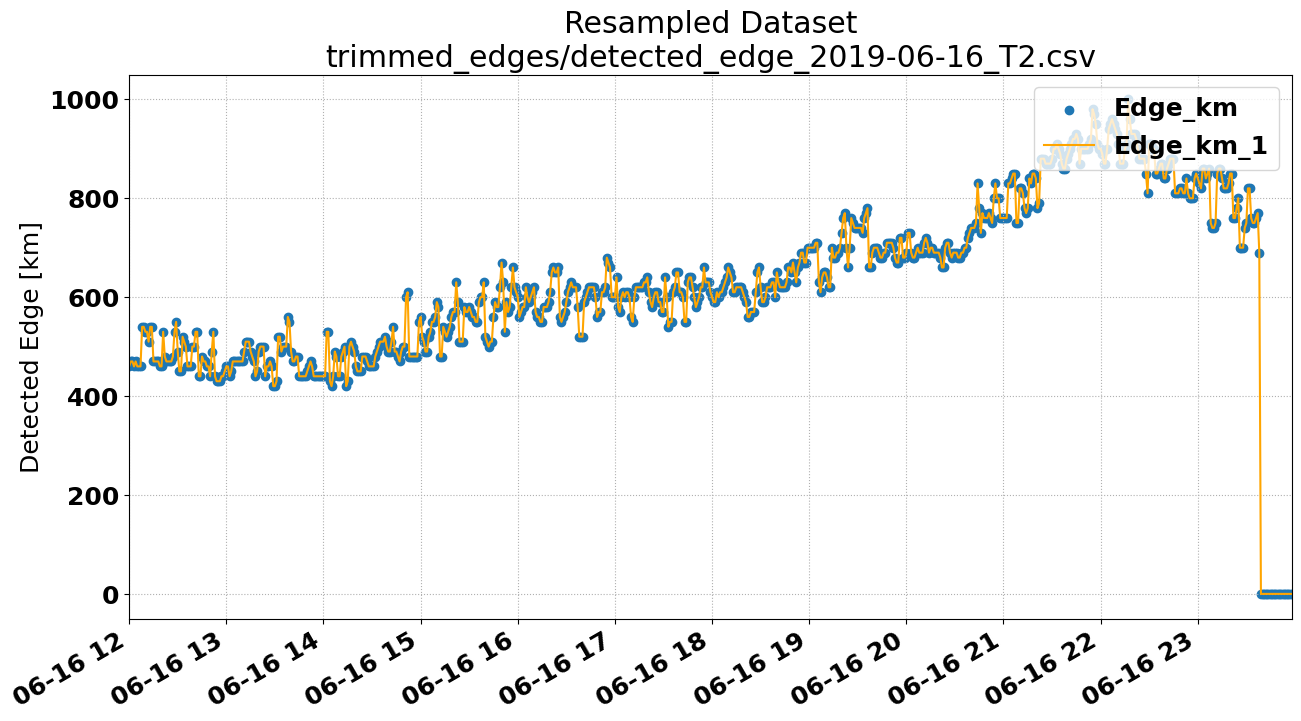

[60.]


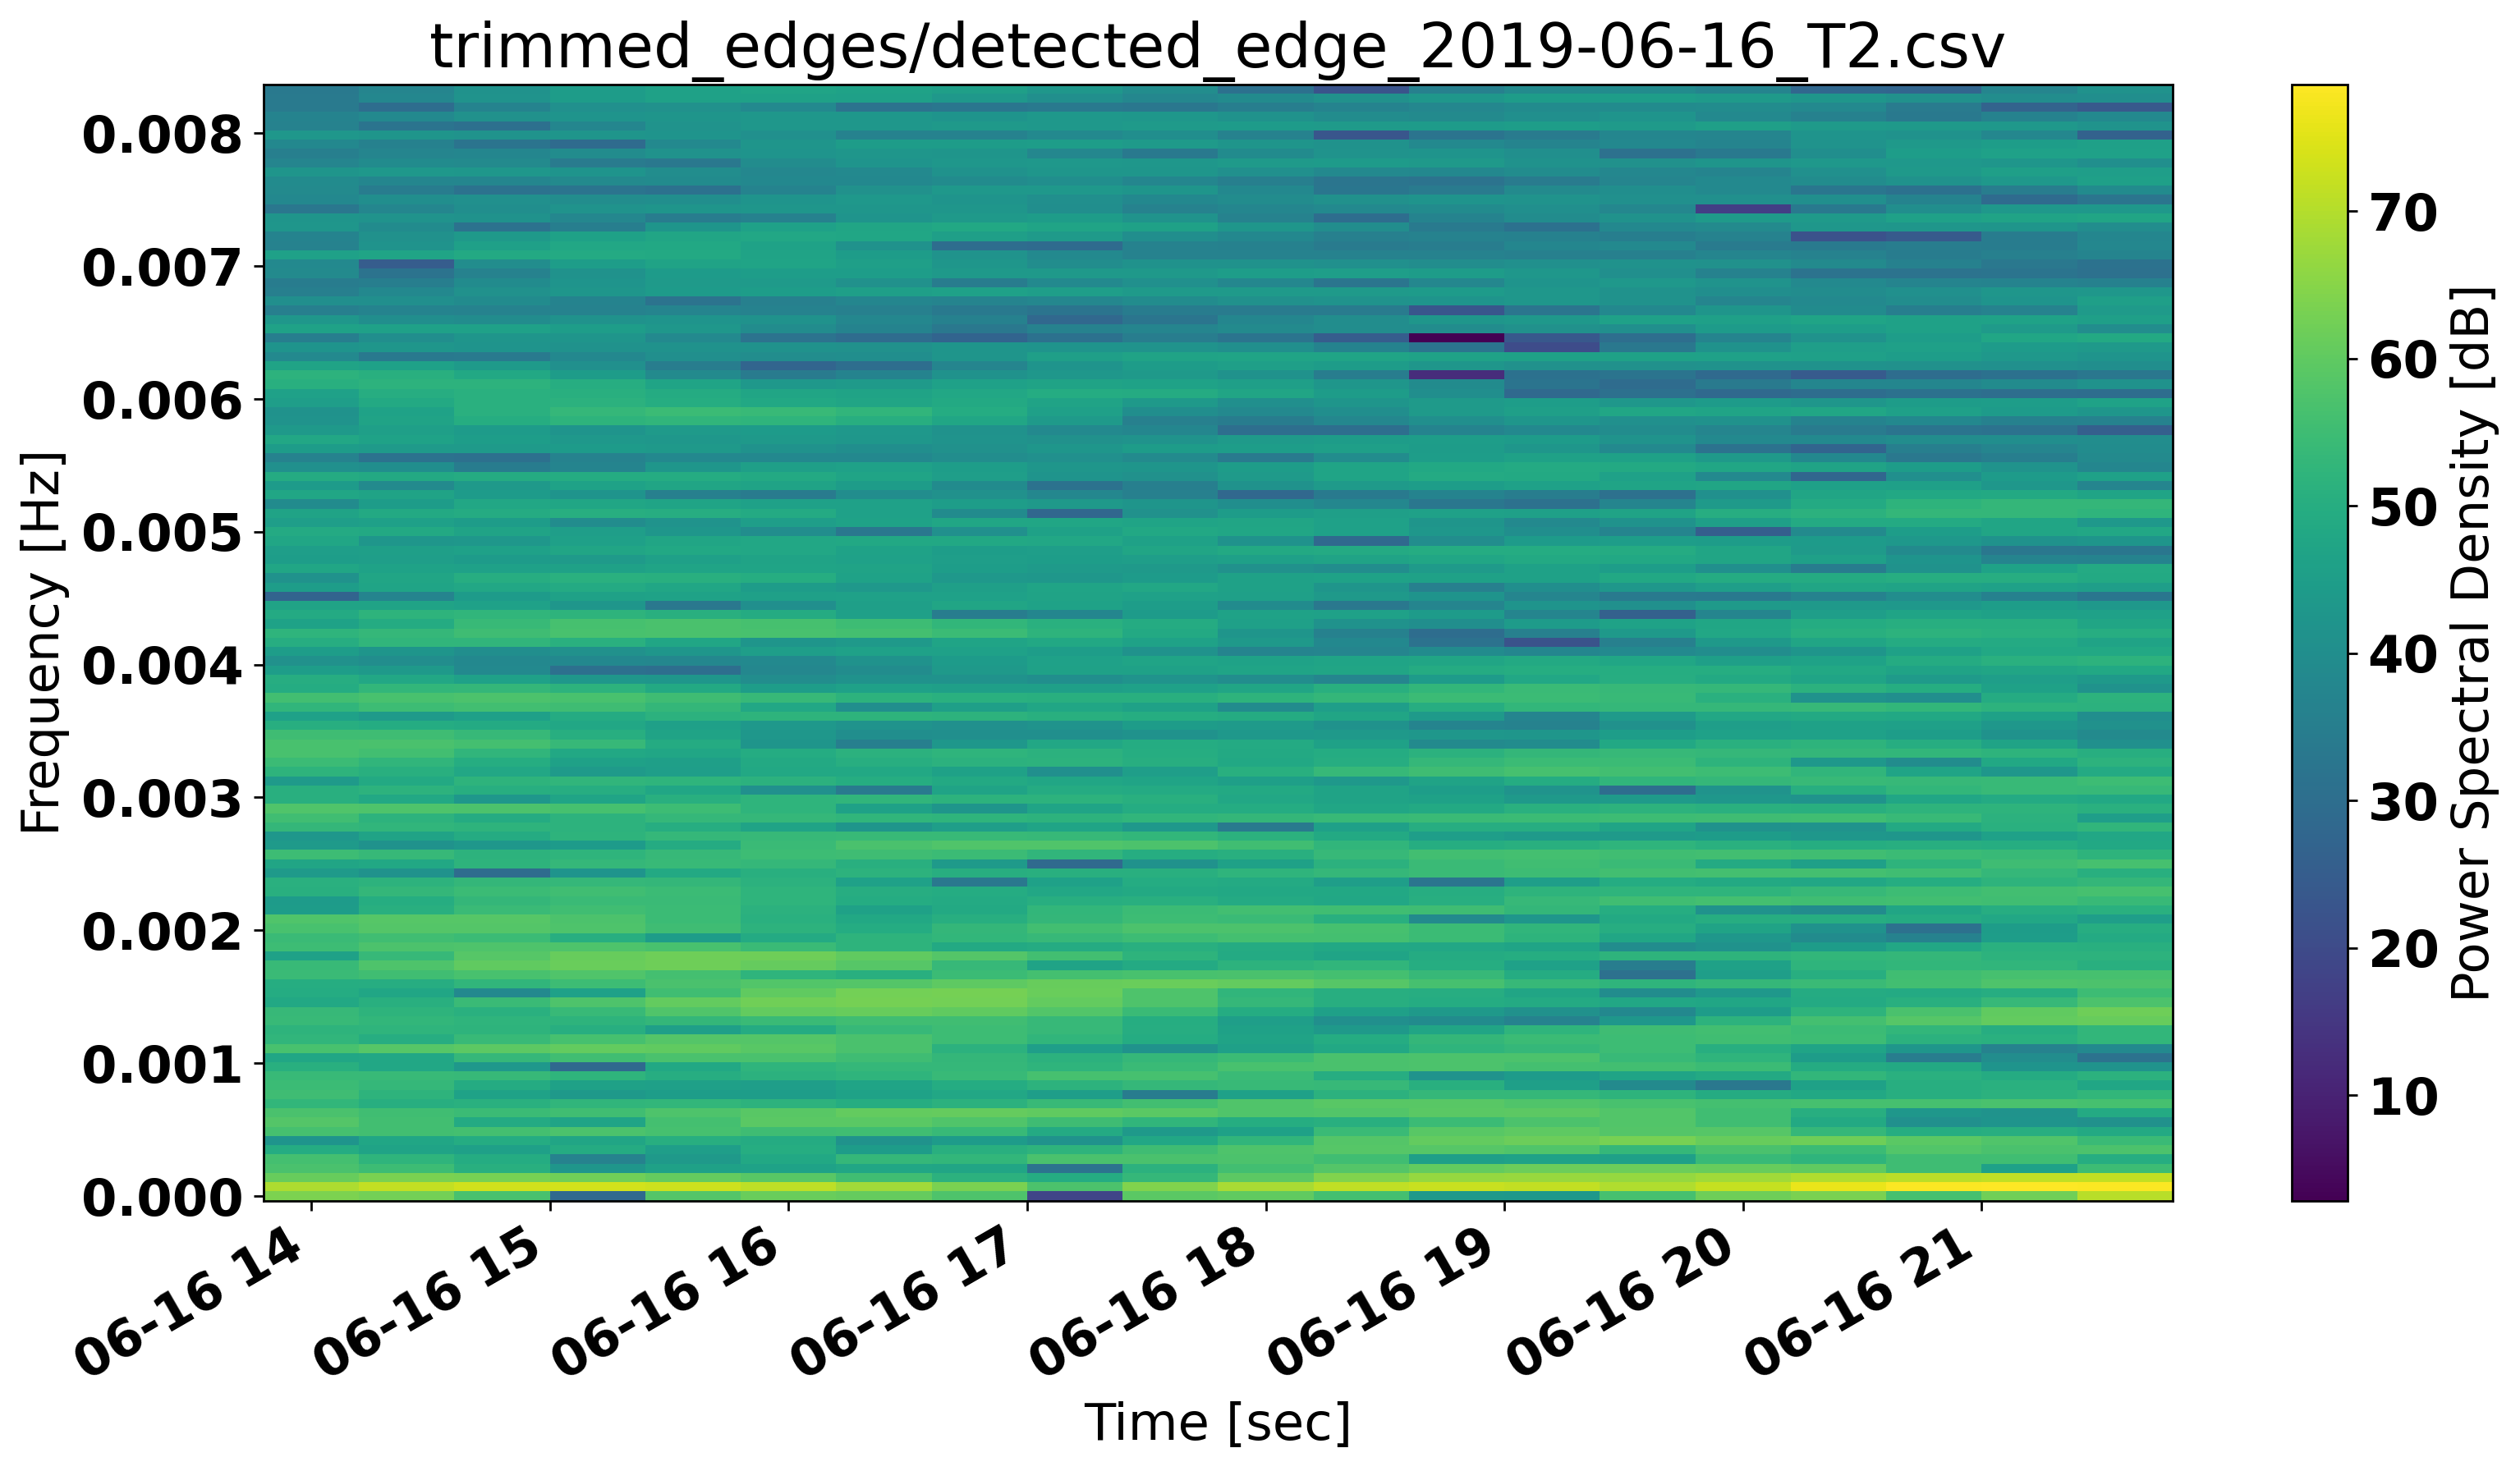

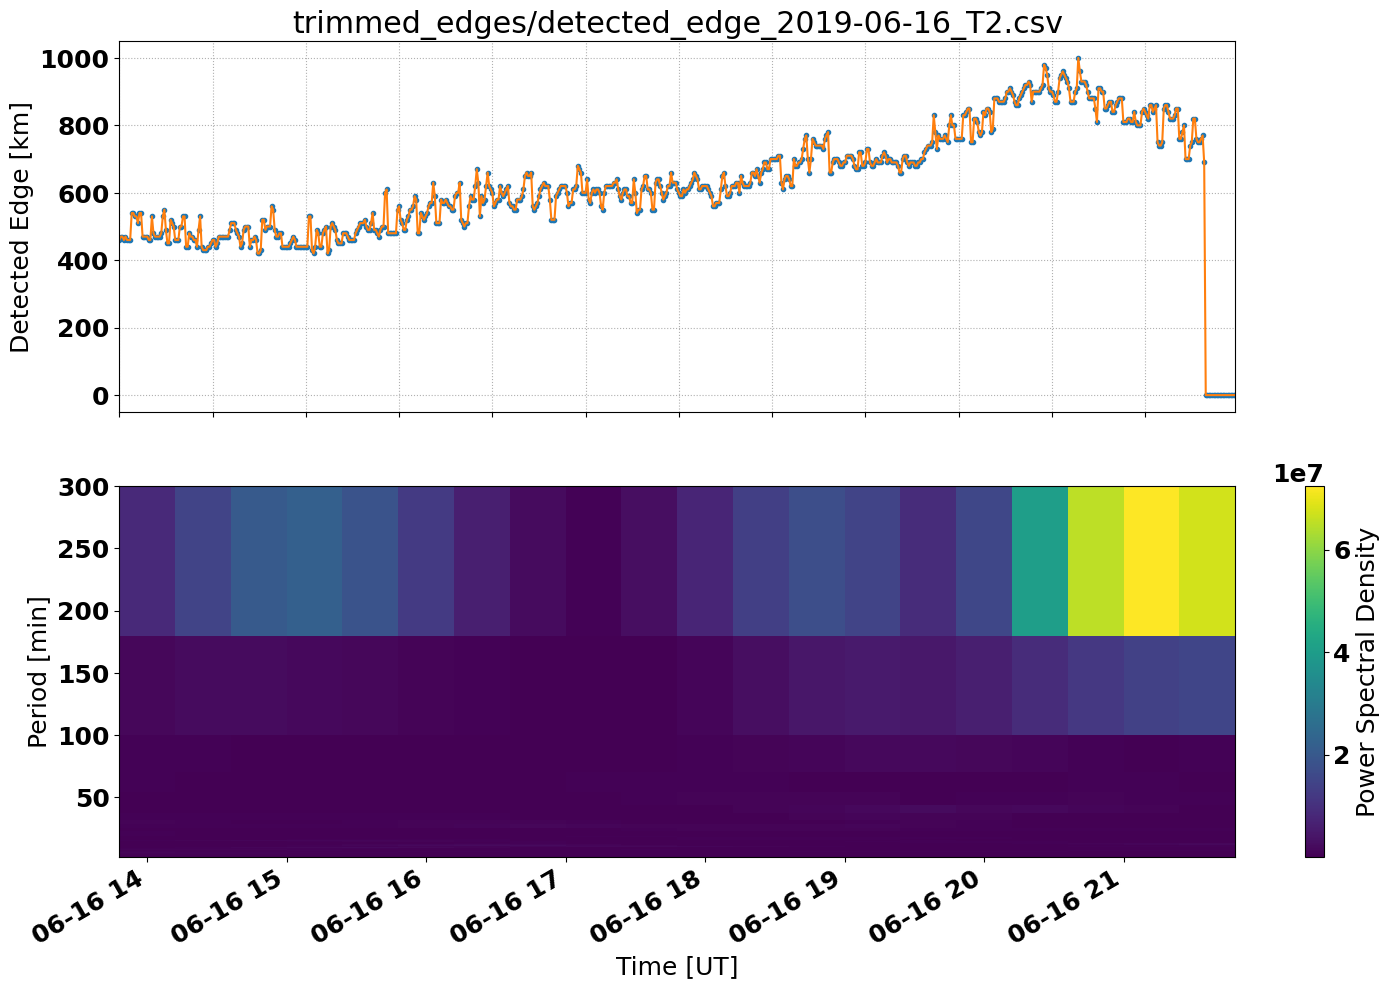

,Edge_km,UTC
0,0,2019-05-26 12:00:00
1,0,2019-05-26 12:01:00
2,0,2019-05-26 12:02:00
3,0,2019-05-26 12:03:00
4,0,2019-05-26 12:04:00
...,...,...
714,0,2019-05-26 23:54:00
715,0,2019-05-26 23:55:00
716,0,2019-05-26 23:56:00
717,0,2019-05-26 23:57:00


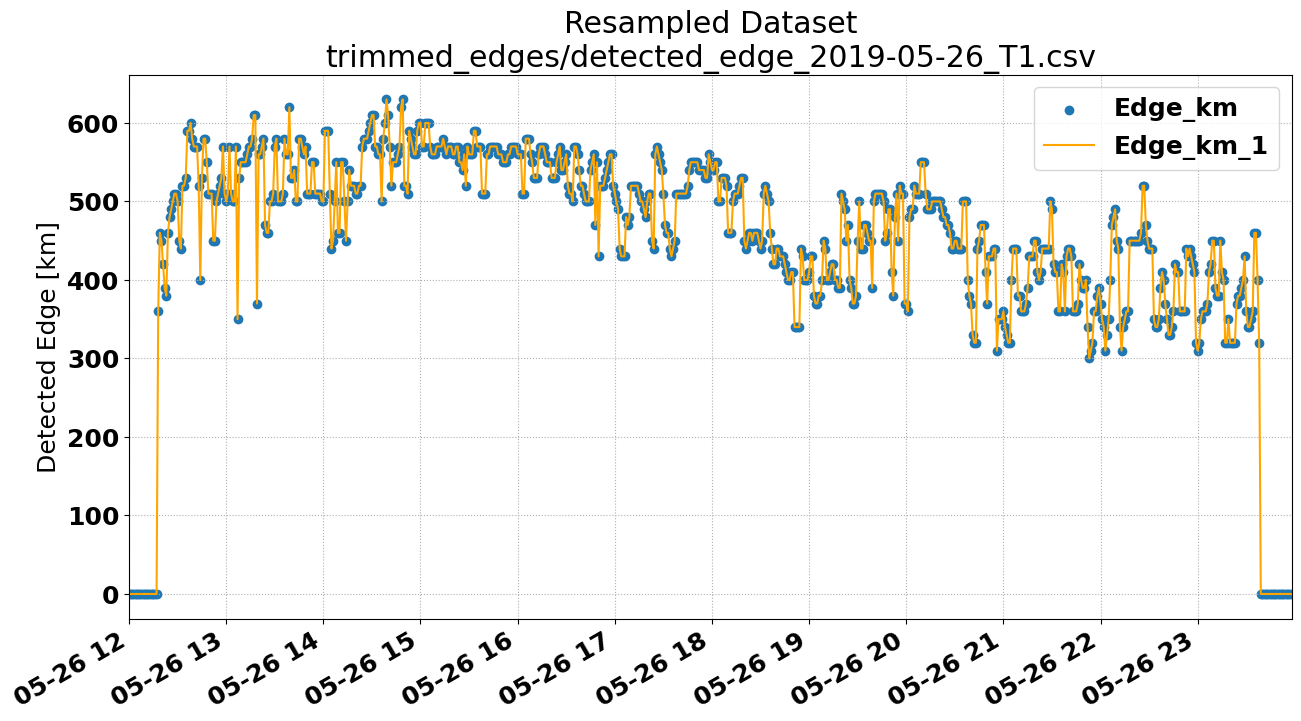

[60.]


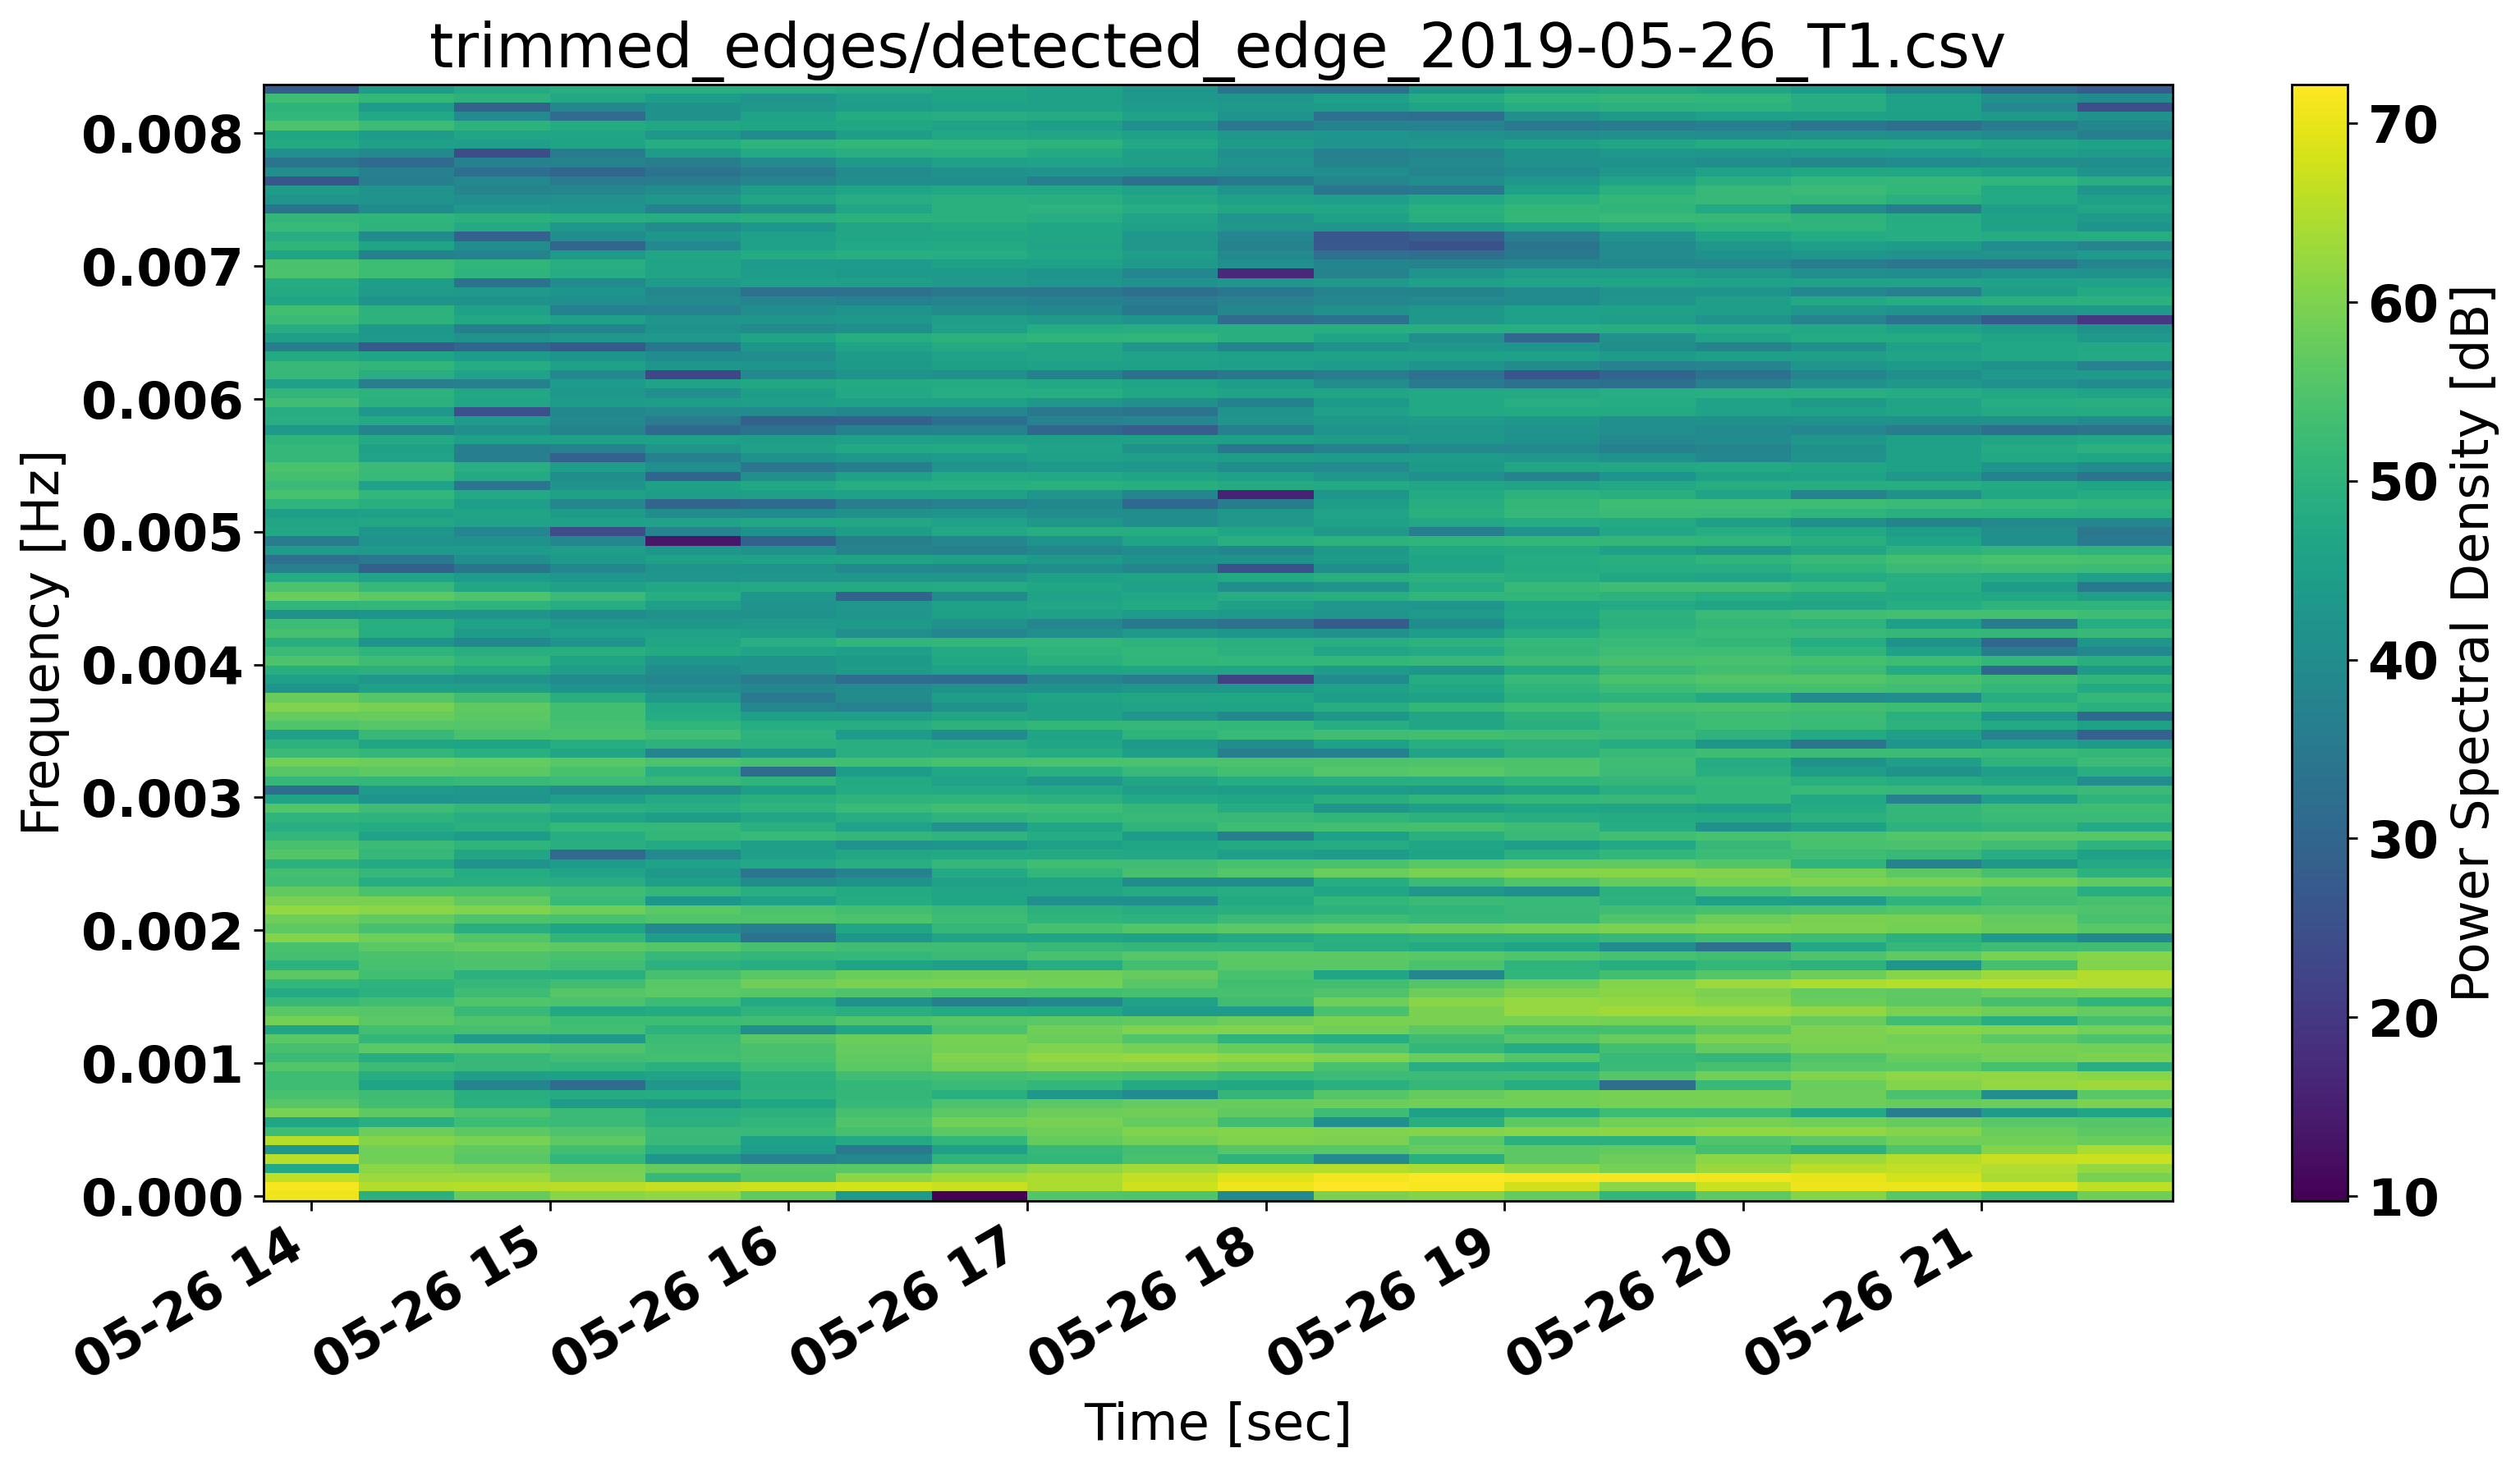

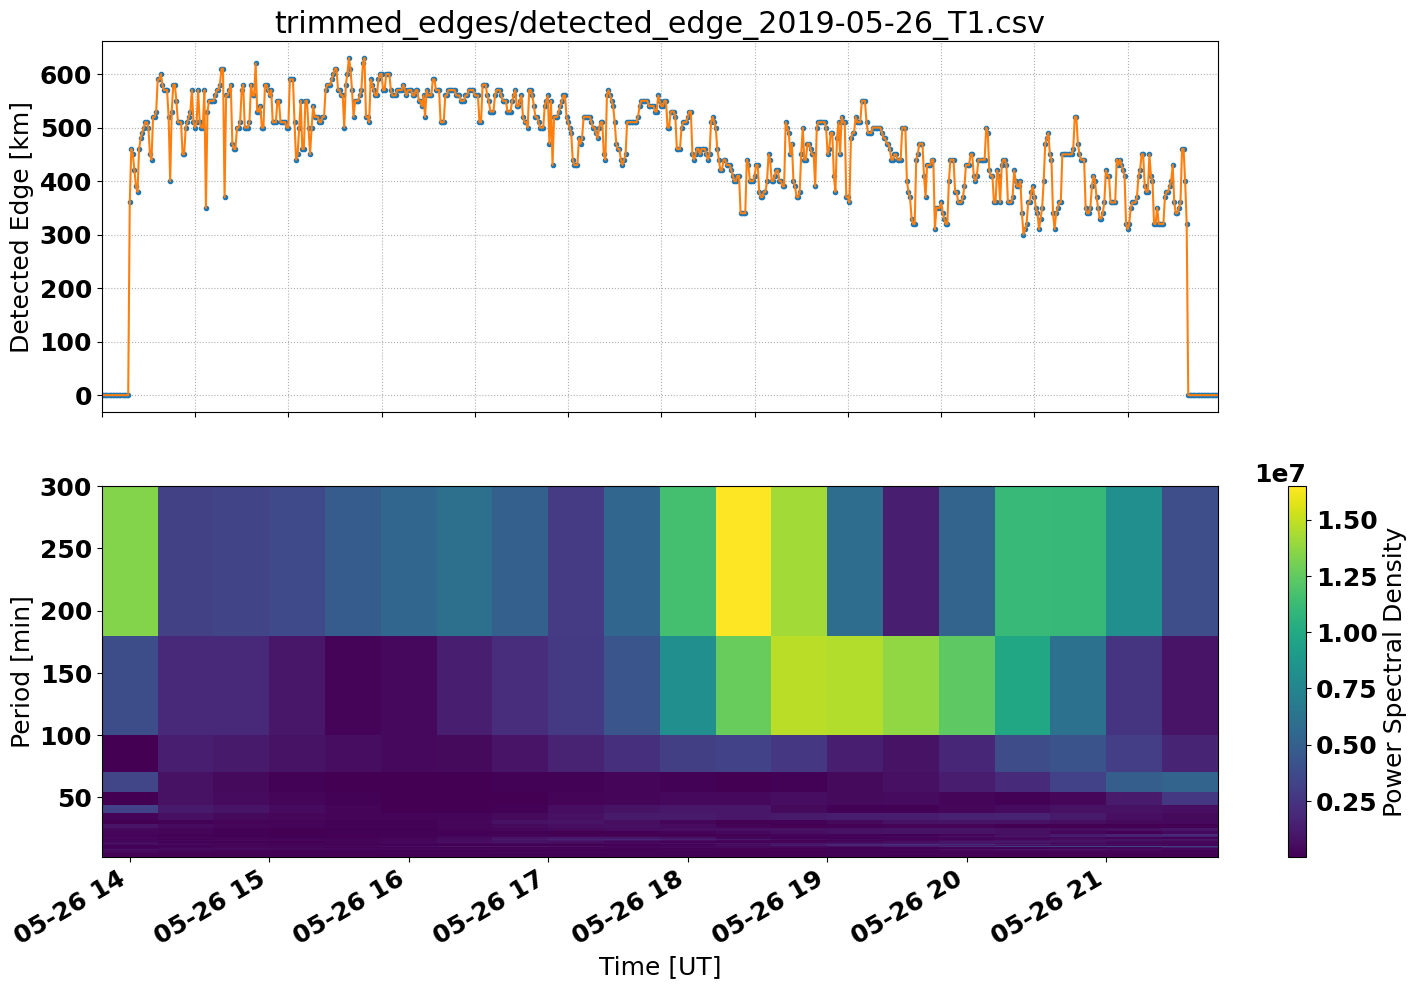

In [12]:
full_df = pd.read_csv('OrderedEdges.csv',index_col=0)
display(full_df.head())

for i in range(5):
    run_all(full_df.index[i])

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)

xx  = rs_df['Edge_km']        # Signal
fs  = 1./dt.total_seconds()   # Sampling Frequency

# Number of segments for each window of the FFT.
# Since MSTIDs have a period of 15 to 60 min, a window
# of 4 hr is reasonable since that will let in four full
# periods of 60 min.
nperseg = int((4.*3600.)/dt.total_seconds())
noverlap = int(0.9*nperseg)
f, t, Sxx = signal.spectrogram(xx, fs, nperseg=nperseg, window='hamming', noverlap=noverlap)
print(len(f))
print(len(t))
print(Sxx.shape)

sns.heatmap(np.log(Sxx))
plt.show()

# Convert seconds to datetimes.
t_dt = [rs_df['UTC'][0] + datetime.timedelta(seconds=x) for x in t]
ax.grid(False)
mpbl = ax.pcolormesh(t_dt, f, 10.*np.log10(Sxx))
cbar = plt.colorbar(mpbl, label='Power Spectral Density [dB]')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
ax.set_title(fname)

fig.autofmt_xdate()
plt.ylim([0,.0005])
plt.show()

# print(Sxx)
periods = list()
for i, col in enumerate(Sxx.transpose()):
#     print(col.shape)
    maxidx = np.argmin(col)
    max_freq = f[maxidx]
#     print(max_freq)
    period = 1 / max_freq
#     print(period)
    periods.append(period)
    
print(periods)
plt.bar(list(range(len(periods))), periods)
# plt.xticks(t_dt)
fig.autofmt_xdate()
plt.show()